# Notebook Proyecto Aprendizaje Profundo

| Nombre | N° Alumno |
| :---: | :---: |
| Vicente García Munizaga | 19637225 |
| Alfredo Medina Klapp | 19642865 |
| Daniel Sebastián Gaete | 19202806 |

# Índice
0. [_Setup_ y librerías](#setup)
1. [Procesamiento y análisis de datos](#parte1)

#0. _Setup_ y librerías <a name="setup"></a>

In [114]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import math
import plotly.express as px
from collections import Counter
from os import listdir
from PIL import Image
from os.path import join
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomRotation
import torch.optim as optim
from tqdm import tqdm
import copy
import random

In [115]:
from IPython.display import clear_output

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

clear_output()

import os, psutil, humanize
import GPUtil as GPU

GPUs = GPU.getGPUs()
if len(GPUs) > 0:
  gpu = GPUs[0]                  # Only one GPU on Colab and isn’t guaranteed

  def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(  \
      psutil.virtual_memory().available ), " I Proc size: " + \
      humanize.naturalsize( process.memory_info().rss))

    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | \
      Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, \
      gpu.memoryUtil*100, gpu.memoryTotal))

  printm()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device: ", device)

Gen RAM Free: 8.6 GB  I Proc size: 4.4 GB
GPU RAM Free: 12964MB | Used: 2137MB | Util  14% |       Total 15360MB
device:  cuda


#1. Procesamiento y análisis de datos <a name="parte1"></a>

In [116]:
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip
!unzip -qq images_background.zip
!unzip -qq images_evaluation.zip

--2023-07-08 05:46:10--  https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip [following]
--2023-07-08 05:46:10--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462886 (6.2M) [application/zip]
Saving to: ‘images_evaluation.zip.1’

images_evaluation.z 100%[===================>]   6.16M  --.-KB/s    in 0.09s   

2023-07-08 05:46:10 (70.8 MB/s) - ‘images_evaluation.zip.1’ save

In [117]:
TRAIN_IMAGES_DIR_BASE = "images_background"
EVALUATION_IMAGES_DIR_BASE = "images_evaluation"

In [118]:
## Leemos todas las imágenes de un alfabeto
def get_alphabet_images_path(base_dir, alphabet_dir_name):
    path_to_alphabet_dir = base_dir + "/" + alphabet_dir_name
    characters = os.listdir(path_to_alphabet_dir)
    images_path = []
    for character in characters:
      images_in_dir = os.listdir(path_to_alphabet_dir + "/" + character + "/")
      images_path += [path_to_alphabet_dir + "/" + character + '/' + image_path for image_path in images_in_dir]
    return np.array(images_path)

In [119]:
## Mostramos las imágenes del input (la cantidad de imágenes
## debe ser un cuadrado perfecto para que quede cuadriculado)
def show_images(images_paths):
  images_per_row = int(math.sqrt(len(images_paths)))
  fig, axs = plt.subplots(images_per_row, images_per_row, figsize=(10, 10))
  for i, image_path in enumerate(images_paths):
      image = plt.imread(image_path)
      row = i // images_per_row
      col = i % images_per_row
      axs[row, col].imshow(image)
      axs[row, col].axis('off')

  plt.tight_layout()
  plt.show()

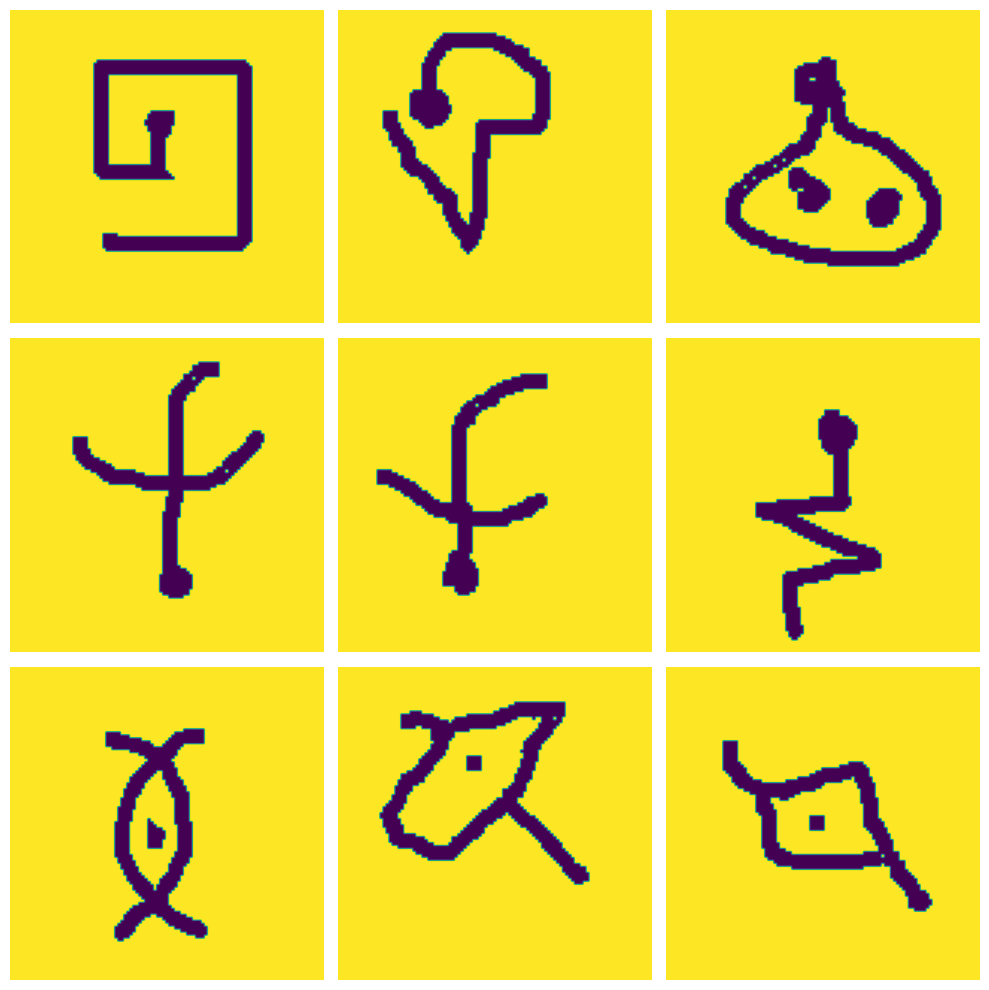

In [120]:
## Mostramos 9 imágenes random del dataset de entrenamiento
images =  np.random.choice(get_alphabet_images_path(TRAIN_IMAGES_DIR_BASE, "Futurama"), size=9, replace=False)
show_images(images)

In [121]:
dataset = ImageFolder('/content/images_background')

In [122]:
dataset_distribution = dict(Counter(dataset.targets))
dataset_distribution_for_plotly = {"Alfabeto (índice)": list(dataset_distribution.keys()), "Número de instancias (imágenes)": list(dataset_distribution.values())}
fig = px.bar(dataset_distribution_for_plotly, x="Alfabeto (índice)", y="Número de instancias (imágenes)")
fig.show()

Los alfabetos no están balanceados porque algunos tienen más caracteres que otros

In [123]:
class Characters(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = []          # Array de arrays de imagenes (por clase)
        self.index_to_class = {}
        self.images = self.build_indices()

    def build_indices(self):
        class_counter = 0 # Contador para guardar el índice de cada imagen
        image_list = []
        imgs_to_class = []
        for alphabet_directory in listdir(self.root):
          alphabet_dir = join(self.root, alphabet_directory)
          for character_directory in listdir(alphabet_dir):
            current_dir = join(alphabet_dir, character_directory)
            if current_dir not in self.index_to_class:
              self.index_to_class[current_dir] = class_counter
              class_counter+=1
            img_of_class = [join(current_dir, _file) for _file in listdir(current_dir)]
            image_list.append(img_of_class)

        return image_list

    def get_image(self, archivo):
        img = Image.open(archivo)
        return img

    def __getitem__(self, idx):
        img_1 = None
        img_2 = None
        label = None

        if idx % 2 == 0: # Misma clase
            characters_of_random_class = random.sample(self.images, 1) # obtenemos las imagenes de alguna clase
            random_imgs_of_class = random.sample(characters_of_random_class[0], 2)
            img_1 = Image.open(random_imgs_of_class[0])
            img_2 = Image.open(random_imgs_of_class[1])
            label = 1.0
        else: # Clases diferentes
            characters_of_random_classes = random.sample(self.images, 2)
            random_imgs_of_class_1 = random.sample(characters_of_random_classes[0], 1)
            random_imgs_of_class_2 = random.sample(characters_of_random_classes[1], 1)
            img_1 = Image.open(random_imgs_of_class_1[0])
            img_2 = Image.open(random_imgs_of_class_2[0])
            label = 0.0
        if self.transform:

            img_1 = self.transform(img_1.convert('RGB'))
            img_2 = self.transform(img_2.convert('RGB'))
        return img_1, img_2, torch.tensor(label, dtype=torch.float)

    def __len__(self):
        counter = 0
        for _class in self.images:
          counter += len(_class)
        return counter

In [124]:
from torchvision.models import resnet18

In [125]:
class SiameseNet(nn.Module):
    def __init__(self, pretrained=False):
        super(SiameseNet, self).__init__()


        self.cnn = resnet18(weights=pretrained)
        self.fc_in_features = self.cnn.fc.in_features

        # eliminamos la ultima capa fc
        self.cnn.fc = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        self.cnn.apply(self.init_weights)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        embeddings1 = self.forward_once(input1)
        embeddings2 = self.forward_once(input2)

        output = torch.cat((embeddings1, embeddings2), 1)

        output = self.fc(output)

        output = self.sigmoid(output)

        return output


In [126]:
class LearningAnalyzer():
    def __init__(self, root, hparams):
        self.root = root
        self.model_non_pretrained = SiameseNet(pretrained=False).to(device)
        self.model_pretrained = SiameseNet(pretrained=True).to(device)
        self.hparams = hparams
        self.threshold = 0.5
        self.ovrl_history = dict()


    def train(self, model, train_loader, test_loader):
      loss_fn = nn.BCELoss()
      optimizer = optim.Adam(model.parameters(), lr=self.hparams["lr"])
      ovrl_history = {
          'train': {'loss': [], 'acc': []},
          'test': {'loss': [], 'acc': []},
      }
      n_epochs = self.hparams["n_epochs"]
      batch_size = self.hparams["batch_size"]
      for epoch in range(n_epochs):
        model.train()
        losses = []
        cum_loss = 0.0
        cum_acc = 0.0

        with tqdm(train_loader, unit='batch', position=0, leave=True) as tepoch:
          tepoch.set_description(f"Epoch {epoch}/{n_epochs}")
          for batch_idx, (imgs1, imgs2, targets) in enumerate(tepoch, start=1):

            optimizer.zero_grad()
            imgs1 = imgs1.to(device)
            imgs2 = imgs2.to(device)
            targets = targets.to(device)


            outputs = model(imgs1, imgs2).squeeze()
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            pred = torch.where(outputs > self.threshold, 1, 0)
            cum_acc += pred.eq(targets.view_as(pred)).sum().item()

            cum_loss += loss.item()
            curr_loss = cum_loss / batch_idx
            curr_acc = cum_acc / (batch_size * batch_idx)

            losses.append(loss.item())

            tepoch.set_postfix(Loss=curr_loss, Acc=curr_acc)

            torch.cuda.empty_cache()

          print()
          print(f"------ Test época {epoch} -------")
          test_acc, test_loss = self.test_model(model, test_loader)
          epoch_loss = float(cum_loss)
          epoch_acc = float(cum_acc / (batch_idx * batch_size))

          # Guardamos el loss y accuracy para la epoca
          ovrl_history['train']['loss'].append(epoch_loss)
          ovrl_history['train']['acc'].append(epoch_acc)
          ovrl_history['test']['loss'].append(test_loss)
          ovrl_history['test']['acc'].append(test_acc)
      return ovrl_history


    def test_model(self, model, test_loader):
      model.eval()
      test_loss = 0
      correct = 0

      criterion = nn.BCELoss()

      with torch.no_grad():
          for (imgs1, imgs2, targets) in test_loader:
              imgs1, imgs2, targets = imgs1.to(device), imgs2.to(device), targets.to(device)
              outputs = model(imgs1, imgs2).squeeze()
              test_loss += criterion(outputs, targets).sum().item()
              pred = torch.where(outputs > self.threshold, 1, 0)
              correct += pred.eq(targets.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      test_acc = 100. * correct / len(test_loader.dataset)

      print(f"\nAverage loss: {test_loss}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_acc}%)\n")

      return test_acc, test_loss

    def generate_report(self, train_loader, test_loader):
      ''' Retorna un reporte con los diferentes entrenamientos (diferentes datasets) '''

      self.ovrl_history = self.train(self.model_pretrained, train_loader, test_loader)


In [127]:
hparams = {"lr": 0.0005 , "batch_size": 32, "n_epochs": 2, "input_size": 224}
analyzer = LearningAnalyzer(TRAIN_IMAGES_DIR_BASE, hparams)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.



In [128]:
_transform = Compose([Resize((hparams["input_size"], hparams["input_size"])),
                    ToTensor(), Normalize((.5, .5, .5), (.5, .5, .5))])
_train = Characters(TRAIN_IMAGES_DIR_BASE, transform=_transform)
_test = Characters(EVALUATION_IMAGES_DIR_BASE, transform=_transform)
train_loader = DataLoader(_train, batch_size=hparams['batch_size'], shuffle=True)
test_loader = DataLoader(_test, batch_size=hparams['batch_size'], shuffle=True)

In [129]:
analyzer.generate_report(train_loader, test_loader)

Epoch 0/2: 100%|██████████| 603/603 [03:26<00:00,  2.92batch/s, Acc=0.826, Loss=0.384]



------ Test época 0 -------

Average loss: 0.010308612368673042, Accuracy: 11438/13180 (86.78300455235205%)



Epoch 1/2: 100%|██████████| 603/603 [03:16<00:00,  3.07batch/s, Acc=0.901, Loss=0.249]



------ Test época 1 -------

Average loss: 0.008406516540179394, Accuracy: 11766/13180 (89.27162367223065%)



In [130]:
# dataset_distribution = dict(Counter(train.imgs_to_class))
# dataset_distribution_for_plotly = {"Clase (índice)": list(dataset_distribution.keys()), "Número de instancias (imágenes)": list(dataset_distribution.values())}
# fig = px.bar(dataset_distribution_for_plotly, x="Clase (índice)", y="Número de instancias (imágenes)")
# fig.show()

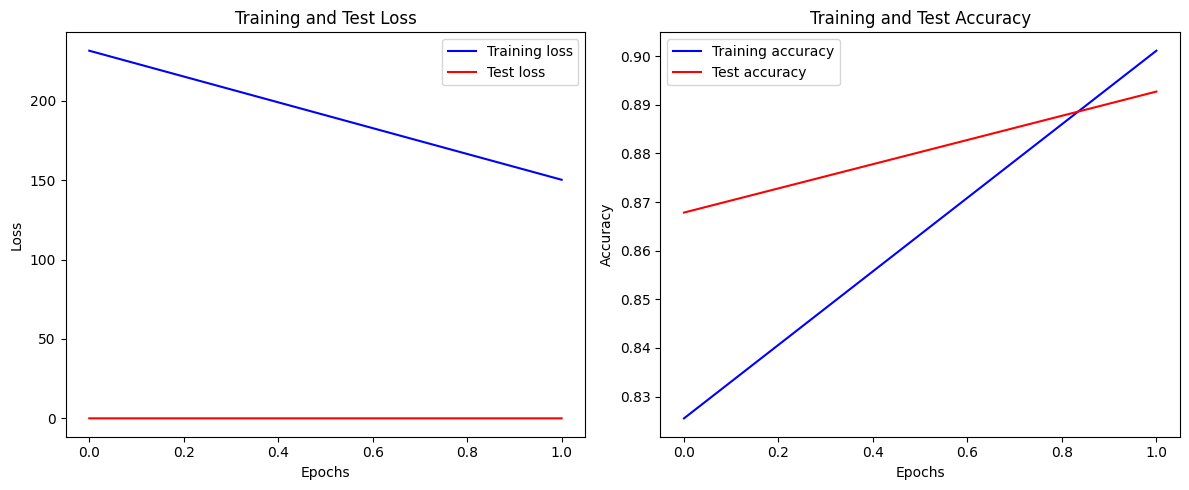

In [136]:
def plot_accuracy_loss(ovrl_history):
    train_loss = ovrl_history['train']['loss']
    train_acc = ovrl_history['train']['acc']
    test_loss = ovrl_history['test']['loss']
    test_acc = [acc/100 for acc in ovrl_history['test']['acc']]

    epochs = range(len(train_loss))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, test_loss, 'r', label='Test loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, test_acc, 'r', label='Test accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_accuracy_loss(analyzer.ovrl_history)


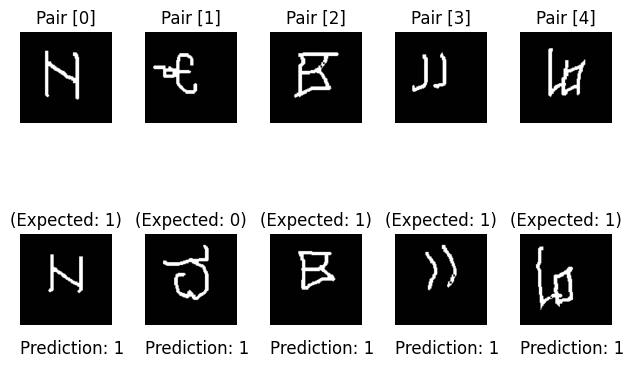

In [132]:

def plot_images(analyzer, model, test_loader, num_pairs=5):
    model.eval()
    test_loss = 0
    correct = 0

    criterion = nn.BCELoss()

    with torch.no_grad():
        for i, (imgs1, imgs2, targets) in enumerate(test_loader):
            imgs1, imgs2, targets = imgs1.to(device), imgs2.to(device), targets.to(device)
            outputs = model(imgs1, imgs2).squeeze()
            pred = torch.where(outputs > analyzer.threshold, 1, 0)
            # Convert tensors to numpy arrays and reshape
            for j in range(num_pairs):
                img1 = np.transpose(imgs1[j].cpu().numpy(), (1, 2, 0))
                img2 = np.transpose(imgs2[j].cpu().numpy(), (1, 2, 0))
                label = f"Expected: {int(targets[j])}"

                plt.subplot(2, num_pairs, j + 1)
                plt.imshow(img1.astype(np.uint8))
                plt.axis('off')
                plt.title(f'Pair [{j}]')

                plt.subplot(2, num_pairs, num_pairs + j + 1)
                plt.imshow(img2.astype(np.uint8))
                plt.axis('off')
                plt.title(f'({label})')
                plt.text(0, -0.15, f'Prediction: {pred[j]}', transform=plt.gca().transAxes, fontsize=12, ha='left', va='top')
            break
    plt.tight_layout()
    plt.show()

plot_images(analyzer, analyzer.model_pretrained, test_loader)